# Project by Hani Shakrah, Ibtisam Ali, Moiez Qamar

## Importing Libraries, Dataset

In [12]:
# Import the `tqdm` module for progress bars.
from tqdm import tqdm

# Import the `matplotlib.pyplot` module for plotting.
import matplotlib.pyplot as plt

# Import the `pathlib` module for working with paths.
import pathlib

# Import the `librosa` module for audio analysis.
import librosa
import librosa.display

# Import the `os` module for working with the operating system.
import os

# Import the `scipy.io.wavfile` module for reading and writing WAV files.
import scipy.io.wavfile
from scipy.io.wavfile import write

# Import the `numpy` module for scientific computing.
import numpy as np

# # Import the `fastai` module for deep learning.
# import fastai

# Import the `glob` module for finding files.
import glob

# # Import the `sounddevice` module for recording audio. May not be needed.
# import sounddevice as sd

# Import the `PIL` module for image processing.
import PIL

# Import the `tensorflow` module for deep learning.
import tensorflow as tf

# Import the `keras` module from `tensorflow` for deep learning.
from tensorflow import keras

# Import the `layers` module from `keras` for deep learning.
from tensorflow.keras import layers

# Import the `Sequential` module from `keras` for deep learning.
from tensorflow.keras.models import Sequential

# Import the `confusion_matrix` module from `sklearn.metrics` for evaluating models.
from sklearn.metrics import confusion_matrix

# Import the `seaborn` module for plotting.
import seaborn as sns

import opendatasets as od
import tensorflow as tf
from PIL import Image
import numpy as np
from google.colab import drive
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from tensorflow.keras import layers, models
from keras.losses import SparseCategoricalCrossentropy
import keras
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling1D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import fast AI stuff
# from fastai import *
# from fastai.vision.all import *
# from fastai.vision.data import ImageDataLoaders
# from fastai.tabular.all import *
# from fastai.text.all import *
# from fastai.vision.widgets import *

In [13]:
# RAVDESS Emotional Speed audio Dataset
od.download("https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio")
# use kaggle credentials

#{"username":"moiezqamar","key":"2d5b1daf22ba80aaafa2a32ecf95038c"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: moiezqamar
Your Kaggle Key: ··········


100%|██████████| 429M/429M [00:19<00:00, 22.6MB/s]


## Conversion of .wav to Mel Spectrograms

In [14]:
# Dictionary of Emotions (will be used later on)
emotion_map = {
    '01' : 'neutral',
    '02' : 'calm',
    '03' : 'happy',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fearful',
    '07' : 'disgust',
    '08' : 'surprised'
}

In [15]:
!rm -r "./ravdess-emotional-speech-audio/audio_speech_actors_01-24"

!mkdir './output'
!mkdir './output/live_images'

# !mkdir './Categorical_Dataset'
# !mkdir './Categorical_Dataset/positive' # happy, surprised, neutral, calm
# !mkdir './Categorical_Dataset/negative' # angry, sad, disgusted, fearful
# !mkdir './Categorical_Dataset/neutral'

!mkdir './DATASET'
!mkdir './DATASET/angry'
!mkdir './DATASET/calm'
!mkdir './DATASET/disgust'
!mkdir './DATASET/fearful'
!mkdir './DATASET/neutral'
!mkdir './DATASET/sad'
!mkdir './DATASET/happy'
!mkdir './DATASET/surprised'

!mkdir './models'

In [16]:
# Define the paths to the three audio folders
AUDIO_FOLDER1 = "./ravdess-emotional-speech-audio/*"

# Define the path to the output dataset folder
DATASET = "./DATASET/"

# Get a list of all the audio files in the three folders
paths = [audioFile for actor in glob.glob(AUDIO_FOLDER1) for audioFile in glob.glob(actor +'/*')]

# Split the list of audio files into groups of 51 files
result = [paths[i:i+51] for i in range(0, len(paths), 51)]

In [17]:
# Number of audio files
print("Number of audio files:",len(paths))

# Number of groups of 51 audio files
print("Number of groups of 51 audio files:",len(result))

Number of audio files: 1440
Number of groups of 51 audio files: 29


In [18]:
# This code will delete all the files in the specified directory.


directories = [DATASET] # Define the list of directories to delete.

# Iterate over the directories.
for directory in directories:
    foldernames = os.listdir(directory) # Get a list of all the folders in the directory.

    # Iterate over the folders.
    for foldername in foldernames:
        folderpath = os.path.join(directory, foldername) # Get the path to the folder.
        if os.path.isdir(folderpath):                    # Check if the folder is a directory.
            filenames = os.listdir(folderpath)           # Get a list of all the files in the folder.

            # Iterate over the files.
            for filename in filenames:
                filepath = os.path.join(folderpath, filename) # Get the path to the file.
                if os.path.isfile(filepath):                  # Check if the file is a file.
                    os.remove(filepath)                       # Delete the file.

In [19]:
def convert_audio_to_melspectrogram(audioPath, savePath):
    """
    Args:
        audioPath (str): The path to the audio file.
        savePath (str): The path to the output file.
    """

    # Load audio file and visualize its waveform (using librosa)
    # The `librosa.load()` function takes two arguments: the path to the audio file and the sample rate.
    # The sample rate is the number of samples per second in the audio file.
    x, sr = librosa.load(audioPath, sr=44100)

    # Trim the audio file to remove silence at the beginning and end.
    # The `librosa.effects.trim()` function takes two arguments: the audio signal and the threshold.
    # The threshold is the minimum amplitude that is considered to be non-silence.
    xt,_=librosa.effects.trim(x)

    x=xt

    # Plot the spectrogram.
    # The `librosa.stft()` function computes the short-time Fourier transform of the audio signal.
    # The `librosa.amplitude_to_db()` function converts the amplitude of the spectrogram to decibels.
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))

    # Apply log transformation on the loaded audio signals
    # The `librosa.display.specshow()` function plots the spectrogram.
    # The `sr` argument specifies the sample rate of the audio signal.
    # The `x_axis` argument specifies the axis along which the time is displayed.
    # The `y_axis` argument specifies the axis along which the frequency is displayed.
    librosa.display.specshow(Xdb, sr=sr, vmin=-60, vmax=60,x_axis='time', y_axis='log',cmap='magma', ax=None)

    # Remove the axis
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    # Save the figure.
    # The `plt.savefig()` function saves the figure to a file.
    # The `savePath` argument specifies the path to the file.
    plt.savefig(savePath)
    plt.clf()

In [20]:
# Convert the audio files to melspectrograms.

# Create a dictionary to count the number of melspectrograms for each emotion.
counts = {}
fileLoc=1
# Iterate over the paths to the audio files.
for path in result:
    files = tqdm(path)
    # Iterate over the audio files in the path.
    for audio_file_path in files:
        files.set_postfix_str(f"{fileLoc}/{len(result)}")

        em = audio_file_path[-18:-16]    # Get the emotion numeric key of the audio file.

        emotion = emotion_map[em]        # Get the emotion category of the audio file.

        # Get the count of melspectrograms for the emotion category.
        count = counts.get(emotion, 1)

        # Create the path to the output melspectrogram.
        p = os.path.join(f"{DATASET}{emotion}", f"{emotion}{str(count).zfill(6)}_{emotion_map[em]}.jpg")

        # Update the count of melspectrograms for the emotion.
        counts[emotion] = count + 1

        # Convert the audio file to a melspectrogram and save it to the output path.
        convert_audio_to_melspectrogram(audio_file_path, p)
    fileLoc+=1

100%|██████████| 12/12 [00:03<00:00,  3.10it/s, 29/29]


<Figure size 640x480 with 0 Axes>

## Loading in Mel Spectrograms for Efficiency

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
folder_path = '/content/DATASET'

# Check if the folder exists
if os.path.exists(folder_path):
    # Change the current working directory to the folder
    os.chdir(folder_path)
    print(f"Current working directory: {os.getcwd()}")
else:
    print("Folder not found. Please check the path.")

Current working directory: /content/DATASET


In [ ]:
# List sub-folders
sub_folders = [f for f in os.listdir() if os.path.isdir(f)]
print("Sub-folders:")
for sub_folder in sub_folders:
    print(sub_folder)

Sub-folders:
disgust
angry
surprised
calm
fearful
sad
neutral
happy


Image format: JPEG
Image size: (640, 480)
Image mode: RGB


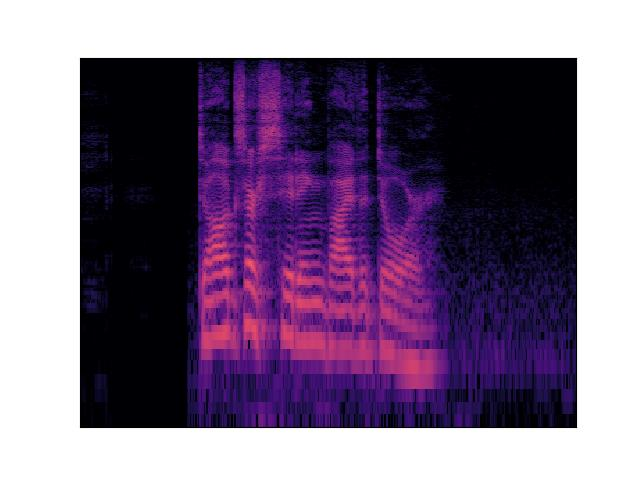

In [ ]:
# Example image
path = os.path.join(folder_path, "neutral")
neutral = tf.data.Dataset.list_files(path + '/*.jpg')
neutral.as_numpy_iterator().next()
image_path = neutral.as_numpy_iterator().next()

img = Image.open(image_path)

print("Image format:", img.format)
print("Image size:", img.size)
print("Image mode:", img.mode)
img

In [ ]:
files = {}

#Loop through each emotion
for emotion in sub_folders:
  files[emotion] = []
  path = os.path.join(folder_path, emotion)

  #loop through pics and append its array to the corresponding emotion in "files" dict
  for pic_name in os.listdir(path):
    pic_path = os.path.join(path,pic_name)

    img = Image.open(pic_path)

    pic_array = np.array(img)

    files[emotion].append(pic_array)

In [ ]:
len(files['disgust'])

192

In [ ]:
files['disgust'][1]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
#Rename keys from emotion to class #

for number, emotion in emotion_map.items():
    files[number] = files.pop(emotion)

In [ ]:
#every array, whether in the 9th position of its emotion list or not, is of the same size
for emotion in files:
   print(files[emotion][9].shape)

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)


## Creating Training and Testing Sets

In [ ]:
X = []
y = []
for label, tensors in files.items():
    X.extend(tensors)
    y.extend([label] * len(tensors))

X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## First Convolutional Neural Network

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(480,640,3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(9, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss= keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 239, 319, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 118, 158, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 156, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 58, 78, 128)       0

In [ ]:
hist = model.fit(X_train, y_train, batch_size=50, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
21/21 [==============================] - 30s 680ms/step - loss: 858.2731 - accuracy: 0.1667 - val_loss: 2.1722 - val_accuracy: 0.2593
Epoch 2/50
21/21 [==============================] - 10s 457ms/step - loss: 2.1327 - accuracy: 0.2153 - val_loss: 1.9352 - val_accuracy: 0.1852
Epoch 3/50
21/21 [==============================] - 9s 455ms/step - loss: 1.9324 - accuracy: 0.2371 - val_loss: 2.0244 - val_accuracy: 0.2593
Epoch 4/50
21/21 [==============================] - 9s 448ms/step - loss: 1.8602 - accuracy: 0.2679 - val_loss: 1.8761 - val_accuracy: 0.2269
Epoch 5/50
21/21 [==============================] - 10s 456ms/step - loss: 1.5978 - accuracy: 0.3730 - val_loss: 1.9171 - val_accuracy: 0.3194
Epoch 6/50
21/21 [==============================] - 9s 453ms/step - loss: 1.1331 - accuracy: 0.5823 - val_loss: 1.8998 - val_accuracy: 0.2870
Epoch 7/50
21/21 [==============================] - 9s 444ms/step - loss: 1.2929 - accuracy: 0.5288 - val_loss: 2.7400 - val_accuracy: 0.3449
E

In [ ]:
predictions = model.predict(X_test,
                         batch_size=16,
                         verbose=1)

27/27 [==============================] - 2s 37ms/step


In [ ]:
predictions=predictions.argmax(axis=1)

In [ ]:
predictions

array([7, 6, 5, 2, 2, 4, 6, 5, 5, 3, 3, 8, 4, 5, 8, 5, 5, 3, 3, 1, 6, 7,
       2, 7, 4, 2, 8, 2, 6, 4, 5, 3, 8, 4, 2, 2, 8, 4, 6, 4, 3, 8, 6, 6,
       6, 3, 7, 5, 4, 6, 5, 5, 2, 6, 7, 4, 2, 5, 2, 7, 2, 3, 2, 8, 7, 4,
       7, 2, 4, 3, 1, 3, 7, 3, 3, 7, 1, 2, 5, 8, 2, 4, 4, 3, 3, 1, 4, 6,
       4, 6, 1, 4, 4, 2, 4, 2, 6, 5, 7, 7, 6, 4, 4, 3, 2, 5, 3, 1, 4, 8,
       4, 6, 8, 3, 7, 5, 5, 4, 2, 5, 7, 1, 8, 7, 8, 3, 3, 1, 2, 1, 1, 8,
       3, 6, 6, 5, 3, 5, 2, 6, 2, 8, 7, 6, 2, 7, 4, 1, 6, 3, 2, 4, 8, 8,
       4, 3, 4, 4, 3, 7, 1, 6, 4, 6, 2, 2, 3, 7, 8, 5, 6, 2, 7, 2, 5, 2,
       3, 5, 2, 4, 4, 2, 2, 7, 2, 4, 7, 6, 8, 5, 6, 4, 5, 7, 1, 1, 8, 4,
       8, 6, 7, 5, 4, 1, 5, 8, 5, 2, 3, 3, 8, 6, 8, 2, 2, 7, 5, 6, 2, 6,
       4, 2, 7, 5, 1, 5, 6, 8, 8, 8, 5, 2, 2, 4, 4, 5, 2, 3, 2, 4, 4, 2,
       3, 6, 4, 6, 2, 2, 3, 8, 3, 8, 2, 6, 6, 8, 5, 7, 6, 5, 6, 4, 7, 7,
       3, 1, 6, 4, 1, 7, 8, 6, 3, 1, 4, 7, 2, 5, 8, 5, 7, 2, 3, 4, 5, 5,
       6, 1, 4, 3, 2, 6, 3, 8, 4, 6, 2, 4, 2, 7, 8,

In [ ]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           1       0.28      0.26      0.27        31
           2       0.51      0.67      0.58        57
           3       0.33      0.41      0.36        49
           4       0.35      0.39      0.37        57
           5       0.58      0.55      0.56        60
           6       0.47      0.45      0.46        58
           7       0.61      0.39      0.47        72
           8       0.36      0.35      0.36        48

    accuracy                           0.44       432
   macro avg       0.44      0.43      0.43       432
weighted avg       0.46      0.44      0.44       432



### The first model resulted in severe overfitting. Different techniques will be used to adjust the model below.

## Second Convolutional Neural Network- Attempting to fix overfitting using dropout layers and adjusted batch size


In [ ]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(480,640,3)))
model2.add(Dropout(0.5))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(Dropout(0.5))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(Dropout(0.5))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())

model2.add(layers.Dense(128, activation='relu'))

model2.add(layers.Dense(9, activation='softmax'))

In [ ]:
# Compile the model
model2.compile(optimizer='adam',
              loss= keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Display the model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 dropout (Dropout)           (None, 478, 638, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 239, 319, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 237, 317, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 118, 158, 64)      0         
 g2D)                                                   

In [ ]:
hist = model2.fit(X_train, y_train, batch_size=10, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
101/101 [==============================] - 38s 247ms/step - loss: 1778.5000 - accuracy: 0.1706 - val_loss: 2.1249 - val_accuracy: 0.1782
Epoch 2/50
101/101 [==============================] - 23s 223ms/step - loss: 2.0799 - accuracy: 0.1984 - val_loss: 2.1128 - val_accuracy: 0.1111
Epoch 3/50
101/101 [==============================] - 23s 225ms/step - loss: 1.9824 - accuracy: 0.2133 - val_loss: 2.1231 - val_accuracy: 0.1134
Epoch 4/50
101/101 [==============================] - 23s 224ms/step - loss: 1.9267 - accuracy: 0.2173 - val_loss: 2.1536 - val_accuracy: 0.1389
Epoch 5/50
101/101 [==============================] - 23s 224ms/step - loss: 1.9460 - accuracy: 0.2202 - val_loss: 2.1794 - val_accuracy: 0.1389
Epoch 6/50
101/101 [==============================] - 23s 225ms/step - loss: 1.9211 - accuracy: 0.2351 - val_loss: 2.2070 - val_accuracy: 0.1389
Epoch 7/50
101/101 [==============================] - 22s 221ms/step - loss: 1.9162 - accuracy: 0.2272 - val_loss: 2.2182 - val

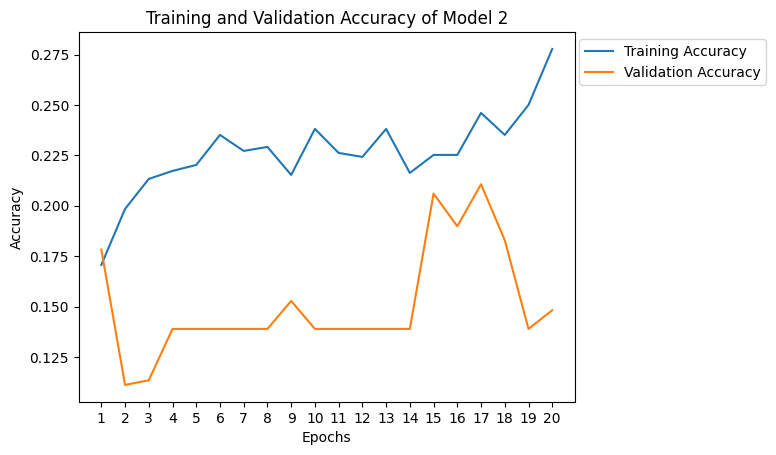

In [ ]:
train_acc = hist.history['accuracy'][0:20]
val_acc = hist.history['val_accuracy'][0:20]

epochs = range(1, 21)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of Model 2')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()


In [ ]:
predictions2 = model2.predict(X_test,
                         batch_size=16,
                         verbose=1)

27/27 [==============================] - 2s 38ms/step


In [ ]:
predictions2=predictions2.argmax(axis=1)

In [ ]:
report2 = classification_report(y_test, predictions2, target_names = emotion_map.values())
print(report2)

              precision    recall  f1-score   support

     neutral       0.09      0.06      0.07        31
        calm       0.36      0.54      0.43        57
       happy       0.16      0.10      0.13        49
         sad       0.32      0.19      0.24        57
       angry       0.27      0.75      0.40        60
     fearful       0.26      0.12      0.16        58
     disgust       0.22      0.11      0.15        72
   surprised       0.07      0.04      0.05        48

    accuracy                           0.26       432
   macro avg       0.22      0.24      0.20       432
weighted avg       0.23      0.26      0.22       432



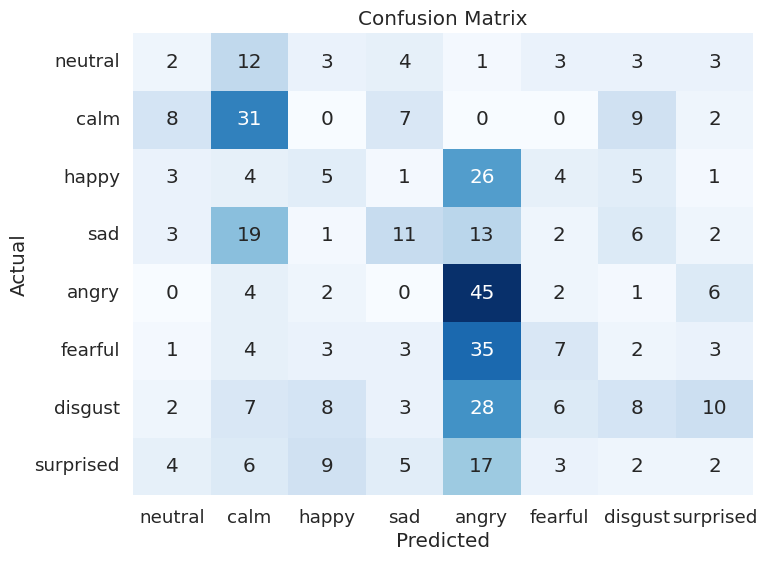

In [ ]:
conf= confusion_matrix(y_test, predictions2)

plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=emotion_map.values(), yticklabels=emotion_map.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Less overfitting was present, but still not the performance we wished.


# ------------------------------------------------------------------------------------------------

# Conclusion

### There were many adjustments we wanted to make to combat the overfitting and poor generalization, but any minor adjustment would result in crashing due to lack of memory. We were heavily restricted in this regard.


### Were we had more memory, we would:

### * Create a more complex CNN with additional convolutional layers to better capture the patterns present and experiment with varying architectures   
### * Add batch normalization layers
### *   Increase the training set by including augmented data
